In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
train_df=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [3]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
# 欠損数の多い順にソートして表示
missing = train_df.isnull().sum().sort_values(ascending=False)
missing[missing > 0]  # 欠損があるカラムだけ表示


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

In [6]:
#欠損値が多いこいつらの処理を考えよう

#PoolQC          
#MiscFeature     
#Alley           
#Fence           
#MasVnrType  
#FireplaceQu

#これらのカラムにおいて欠損値というのは、普通の家にはないものであるから
#有るか無いかの有無フラグで考えてカラムは消さないでおく
#mapメソッドを用いてあるやつを1,ないやつを0と置くことでエンコーディングする
#まあこれはdefの中の処理に入れとけばいいな

In [7]:
#そして今回がタイタニック号と大きく異なるのが圧倒的なカラムの多さと、object型の割合の高さである
#あまり値段に直結しなさそうなカラムは消したいなっていうお気持ちがありますね
#それでobject型のカラムの処理はone-hotでやる

In [8]:
#数値カラムの処理
#目的変数SalePriceとの相関係数を調べてその絶対値が低いものを消す方針で行く
import seaborn as sns
import matplotlib.pyplot as plt

#corrメソッドは各カラム同士の相関係数を行列で返す
corr = train_df.corr(numeric_only=True)["SalePrice"].sort_values(ascending=False)
corr


SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

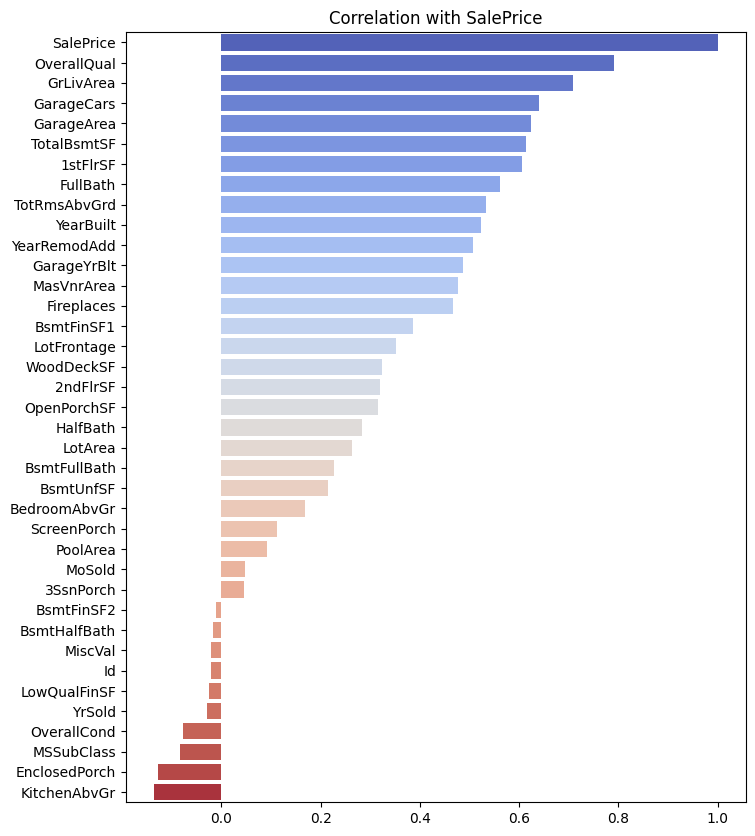

In [9]:
#SalePriceとの相関係数をseabornの棒グラフを使って可視化してみよう

plt.figure(figsize=(8, 10))
sns.barplot(x=corr.values, y=corr.index, palette="coolwarm")
plt.title("Correlation with SalePrice")
plt.show()


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


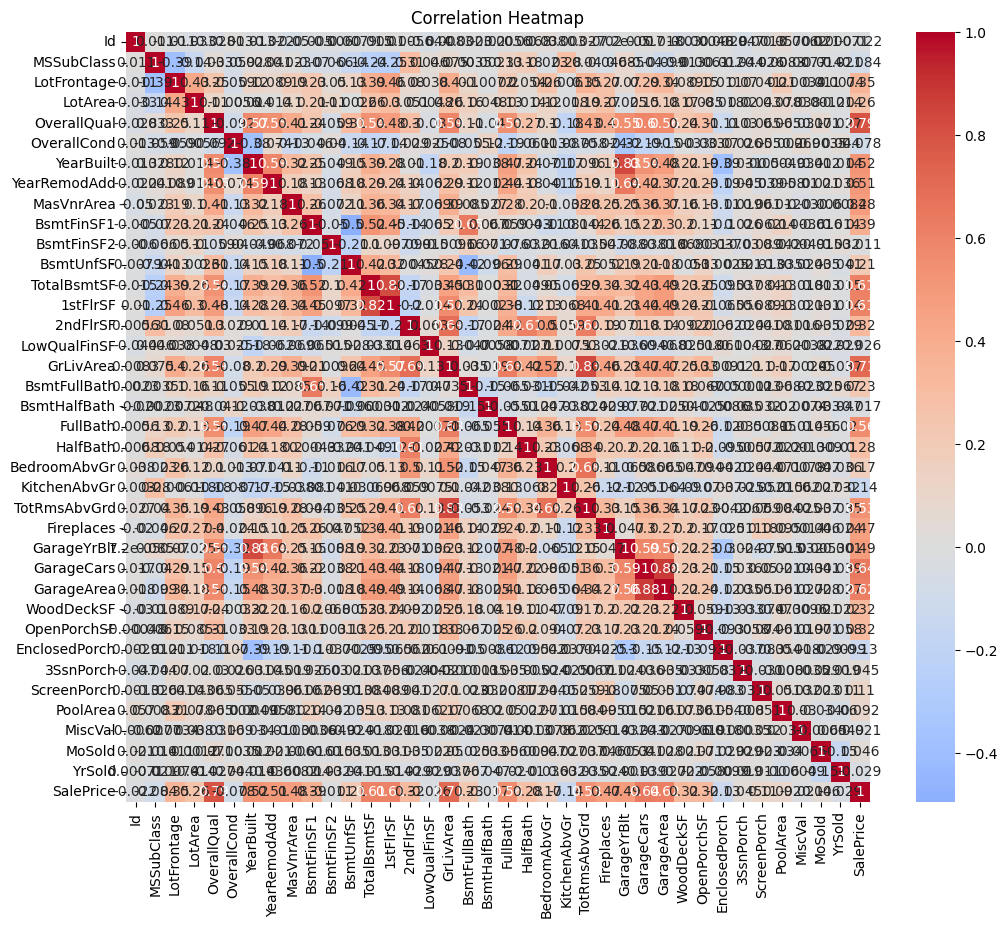

In [10]:
#相関係数をヒートマップを用いて可視化してみよう

plt.figure(figsize=(12, 10))
sns.heatmap(train_df.corr(numeric_only=True), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


In [11]:
#SalePriceとの相関係数の絶対値が0.1未満の特徴量を削除しようかな
#でもそれならtrain、test両方に対して削除しないといけないね
#てことはdefに含める処理だな

In [12]:
#絶対値が0.1以下の特徴量を抽出してみよう

corr[abs(corr) <= 0.1]

PoolArea        0.092404
MoSold          0.046432
3SsnPorch       0.044584
BsmtFinSF2     -0.011378
BsmtHalfBath   -0.016844
MiscVal        -0.021190
Id             -0.021917
LowQualFinSF   -0.025606
YrSold         -0.028923
OverallCond    -0.077856
MSSubClass     -0.084284
Name: SalePrice, dtype: float64

In [13]:
#ここまでで数値変数の処理はいったん終わり
#ここからはカテゴリカル変数の処理について考えていこう


In [14]:
#カテゴリカル変数の処理は相関比を用いてSalePriceとの相関を調べる
#0.01 程度 → ほとんど関係ない

#0.06 程度 → 弱い関係

#0.14 以上 → 強い関係

#これをもとにすると0.05以下の特徴量は削除していいかなと思う

In [15]:

def eta_squared_v2(x, y):
    df_tmp = pd.DataFrame({"x": x, "y": y}).dropna()
    y_mean = df_tmp["y"].mean()
    ssb = sum(df_tmp.groupby("x")["y"].apply(lambda g: len(g) * (g.mean() - y_mean)**2))
    sst = ((df_tmp["y"] - y_mean)**2).sum()
    return ssb / sst if sst > 0 else np.nan

# すべてのカテゴリ変数について η² を計算
eta_dict = {}
for col in train_df.select_dtypes(include=["object", "category"]).columns:
    eta_dict[col] = eta_squared_v2(train_df[col], train_df["SalePrice"])

# 0.05 以下の特徴量をカウント
low_eta = [col for col, val in eta_dict.items() if pd.notna(val) and val <= 0.05]
print(f"相関比が0.05以下のカテゴリ特徴量の数: {len(low_eta)}")
low_eta



相関比が0.05以下のカテゴリ特徴量の数: 16


['Street',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'RoofMatl',
 'ExterCond',
 'BsmtCond',
 'BsmtFinType2',
 'Heating',
 'Functional',
 'GarageQual',
 'GarageCond']

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [17]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


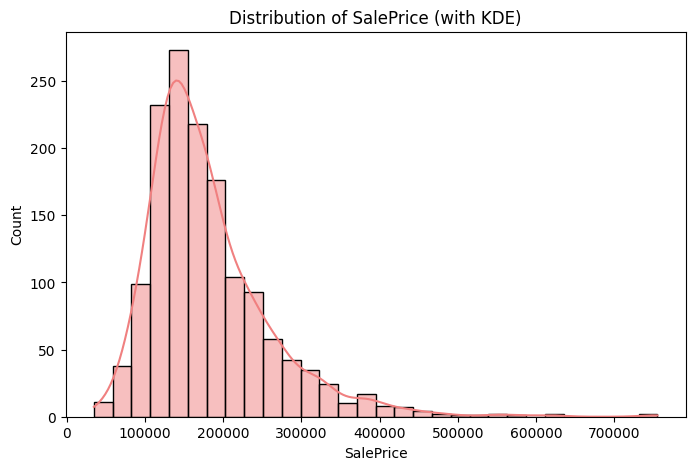

In [18]:
#目的変数であるsalepriceの分布を調べよう

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(train_df["SalePrice"], bins=30, kde=True, color="lightcoral")
plt.title("Distribution of SalePrice (with KDE)")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.show()


In [19]:
#もう一度欠損値の数を確認

missing = train_df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

In [20]:
train_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


<Axes: xlabel='PoolQC', ylabel='SalePrice'>

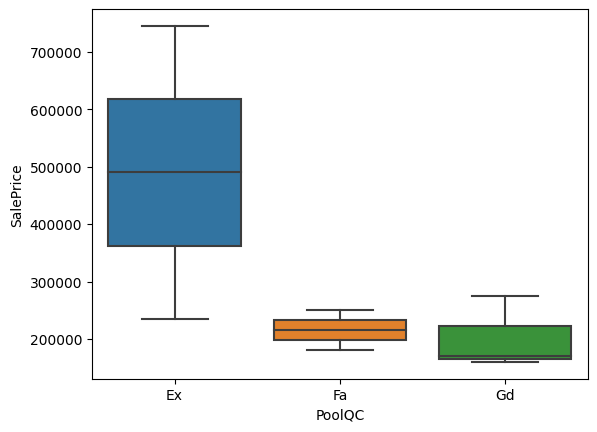

In [21]:
#プールのクオリティとsalepriceの相関関係を調べる
import seaborn as sns
sns.boxplot(x='PoolQC', y='SalePrice', data=train_df)


In [22]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [23]:
# 欠損値処理の方針
none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu']

# ① Noneで埋める（主に「その設備がない」など意味があるカテゴリ）(none自体に意味があるのでnanをnoneに変換)
for col in none_cols:
    train_df[col] = train_df[col].fillna('None')
    test_df[col] = test_df[col].fillna('None')

# ② 数値変数 → 中央値で埋める
# num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns #数値変数をnum_colsの中に入れる
# for col in num_cols:
#     median_val = train_df[col].median()
#     train_df[col] = train_df[col].fillna(median_val)
    #test_dfにsalepriceのカラムはないのでこれｗtrain_dfの中央値で埋めるのはおかしい
    #test_df[col] = test_df[col].fillna(median_val)だからこうやって書いちゃうのはダメ

# continue は「次のループへ進む（今のは飛ばす）」という意味。
# 数値変数 → 中央値で埋める
for col in train_df.select_dtypes(include=[np.number]).columns:
    if col == "SalePrice":  # SalePrice は目的変数なのでスキップ
        continue
    median_val = train_df[col].median()
    train_df[col] = train_df[col].fillna(median_val)
    if col in test_df.columns:  # test_dfに存在する列だけ埋める
        test_df[col] = test_df[col].fillna(median_val)


# ③ カテゴリ変数 → 最頻値で埋める
cat_cols = train_df.select_dtypes(include=['object']).columns
for col in cat_cols:
    mode_val = train_df[col].mode()[0]
    train_df[col] = train_df[col].fillna(mode_val)
    test_df[col] = test_df[col].fillna(mode_val)


In [24]:
# 特徴量の削除

# --- 相関比（eta squared）を計算する関数 ---
def eta_squared(x, y):
    df_tmp = pd.DataFrame({"x": x, "y": y}).dropna()
    y_mean = df_tmp["y"].mean()
    ssb = sum(df_tmp.groupby("x")["y"].apply(lambda g: len(g) * (g.mean() - y_mean)**2))
    sst = ((df_tmp["y"] - y_mean)**2).sum()
    return ssb / sst if sst > 0 else np.nan


# --- 数値変数とカテゴリ変数を抽出 ---
num_cols = train_df.select_dtypes(include=["int64", "float64"]).columns
cat_cols = train_df.select_dtypes(include=["object", "category"]).columns

# SalePriceを除外
num_cols = [col for col in num_cols if col != "SalePrice"]

# --- 数値変数：相関係数 ---
corr_with_saleprice = train_df[num_cols].corrwith(train_df["SalePrice"]).abs()#salepriceとの相関係数の絶対値を求める
low_corr_num = corr_with_saleprice[corr_with_saleprice < 0.1].index.tolist()



# --- カテゴリ変数：相関比 ---
eta_dict = {}
for col in cat_cols:
    eta_dict[col] = eta_squared(train_df[col], train_df["SalePrice"])

low_corr_cat = [k for k, v in eta_dict.items() if (v is not None and v < 0.05)]


# --- 両方をまとめて削除 ---
drop_cols = low_corr_num + low_corr_cat
print(f"\n削除する特徴量の合計: {len(drop_cols)}個")

train_df = train_df.drop(columns=drop_cols)
test_df = test_df.drop(columns=[c for c in drop_cols if c in test_df.columns])



削除する特徴量の合計: 31個
